## 0. 이 작업은요
- 전이학습폴더의  2.VGG16을이용한 전이학습과 같은 코드이며
  1번 개고양이 구별하기와 같은 코드임

In [ ]:
### 드라이브 마운트함. 압축파일이 있는 폴더로
%cd /content/drive/MyDrive/한경IT_5차/3. CNN/실습/5. 실습_개고양이,교통표지판

/content/drive/MyDrive/한경IT_5차/3. CNN/실습/5. 실습_개고양이,교통표지판


## ▶작업1: 학습데이터셋 준비하기
-  [런타임-유형변경-GPU]
-  현재 코드가 있는 폴더에 zip파일 업로드함.
  - https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?select=Train  에서 다운로드한 자료임


In [23]:
# 이 작업진행후 코렙 왼쪽의 '파일' 영역의 업로드한 압축파일을 해제함
import os
import zipfile

zipFile = 'archive.zip'  # 압축해제할 파일 원본
extractFile = zipfile.ZipFile(zipFile, 'r')    # 이 파일을 읽기전용으로 읽어서

# /content/data 폴더에 압축해제하겠음, data 폴더가 생성됨
# 이 폴더는 다음에 실행하면 없어지는 폴더임. 상황에 따라 현재 자기 작업폴더에 압축해제해도 됨
# 이렇게 작업하면 장점은, 드라이브의 저장공간을 차지하지 않음

extractFile.extractall('/content/data')  
extractFile.close()  

In [24]:
## 텐서플로우에 넣을 train과 test 자료 경로 설정
data_dir= '/content/data/train'
data_dir

'/content/data/train'

## ▶작업2: 모델제작하기

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [36]:
batch_size = 32   # 한셋트에 몇개의 자료를 넣을것인가? 기본 32로 많이하나 조정해도됨. 숫자를 적게할수록 처리속도가 느려짐
img_height = 180
img_width = 180


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,      # train 데이터 폴더를 지정함.
    validation_split=0.2,   # 트레이닝과 테스트 폴더가 별도로 제공됨으로 이 코드에서는 사용하지 않음.
    subset="training",      # 트레이닝과 테스트 폴더가 별도로 제공됨으로 이 코드에서는 사용하지 않음.
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size) 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,    # test 데이터폴더를 지정함.
  seed=123,
   validation_split=0.2,   # 트레이닝과 테스트 폴더가 별도로 제공됨으로 이 코드에서는 사용하지 않음.
  subset="training",      # 트레이닝과 테스트 폴더가 별도로 제공됨으로 이 코드에서는 사용하지 않음.
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 31368 files for training.
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


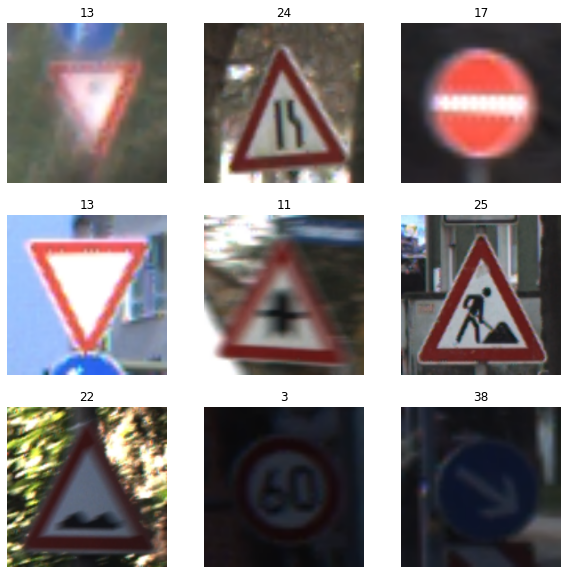

In [37]:
##########################
### 참고 샘플이미지
##########################
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):   # train_ds.take(1)은 32개의 첫번째 세트을 의미,  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

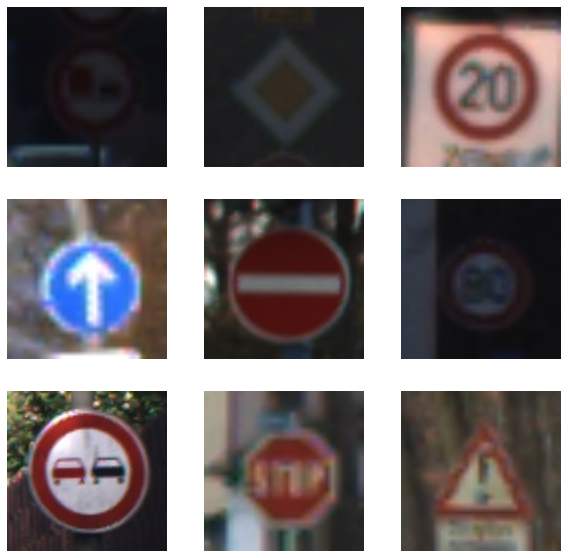

In [40]:
## 증강잘되어 있는지 확인용
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):  # train_ds.take(1)첫번째 32개 세트 작업
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

In [41]:
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
base_model = VGG16(input_shape=(img_height,img_width,3),
                   include_top=False,
                   weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [42]:
## 클래스 네임의 갯수만큼 
prediction_layer = tf.keras.layers.Dense(43,activation='softmax')  


In [43]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

## ▶작업3: 모델실행
- 모델결과의 h5를 저장하기 위한 드라이브 마운트 작업은 선택사항임.
- 여기서는 드라이브 마운트 하지 않고 /content/  에 생성되게 한뒤 모델성능이 좋으면 다운로드하려함.

In [44]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                           

In [45]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # y값이 원핫인코딩이 안되어 있어서임
              metrics=['accuracy'])


# 모델 최적화를 위한 설정 구간입니다.

modelpath="/content/교통표지판_(180,180).hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, 
                               monitor='val_loss',       # val_loss값을 기준으로
                               verbose=1,                # 실행결과를 화면에 출력함. verbose=0하면 실행결과가 화면에 나타나지않음
                               save_best_only=True)  # 가장좋은(즉 loss숫자가 가장 낮은) 모델을 저장함

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=5) # 실행하다가 5번이상 더 좋은 결과가 없으면 중단

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_callback,checkpointer]
)

Epoch 1/100
980/981 [============================>.] - ETA: 0s - loss: 2.6269 - accuracy: 0.2943
Epoch 1: val_loss improved from inf to 2.18432, saving model to /content/교통표지판_(180,180).hdf5
981/981 [==============================] - 58s 58ms/step - loss: 2.6268 - accuracy: 0.2943 - val_loss: 2.1843 - val_accuracy: 0.4213
Epoch 2/100
979/981 [============================>.] - ETA: 0s - loss: 2.0741 - accuracy: 0.4341
Epoch 2: val_loss improved from 2.18432 to 1.89980, saving model to /content/교통표지판_(180,180).hdf5
981/981 [==============================] - 57s 58ms/step - loss: 2.0737 - accuracy: 0.4343 - val_loss: 1.8998 - val_accuracy: 0.4928
Epoch 3/100
979/981 [============================>.] - ETA: 0s - loss: 1.8819 - accuracy: 0.4780
Epoch 3: val_loss improved from 1.89980 to 1.74090, saving model to /content/교통표지판_(180,180).hdf5
981/981 [==============================] - 56s 58ms/step - loss: 1.8815 - accuracy: 0.4781 - val_loss: 1.7409 - val_accuracy: 0.5335
Epoch 4/100
980/981 

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 22ms/step
틀렸음


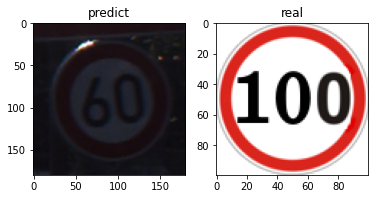

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
틀렸음


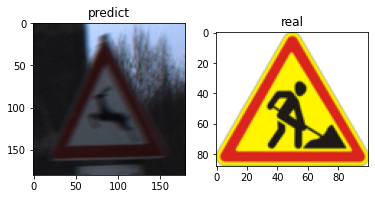

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
틀렸음


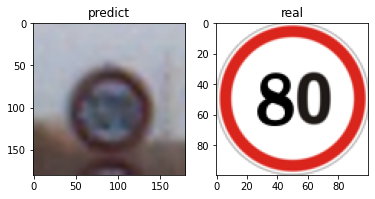

--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
틀렸음


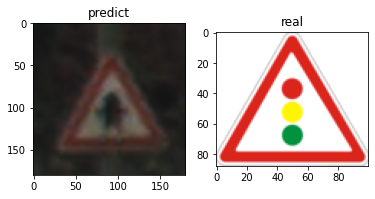

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
정답


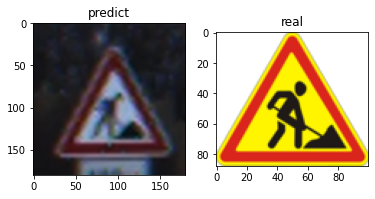

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
틀렸음


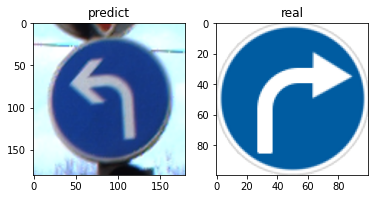

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
정답


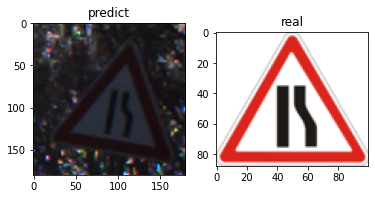

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


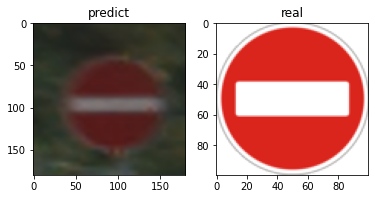

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
틀렸음


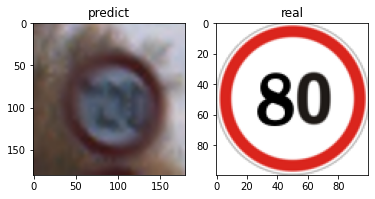

--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
틀렸음


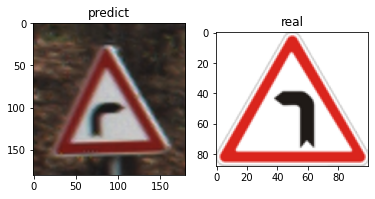

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
정답


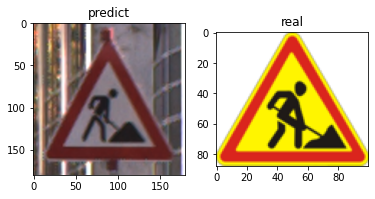

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


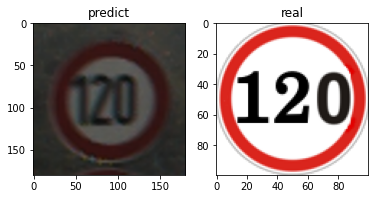

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
정답


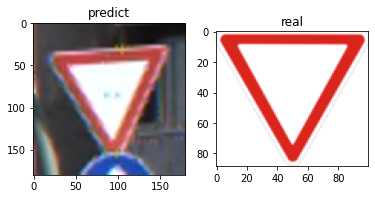

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
정답


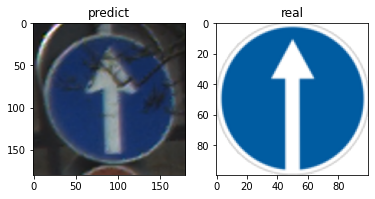

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


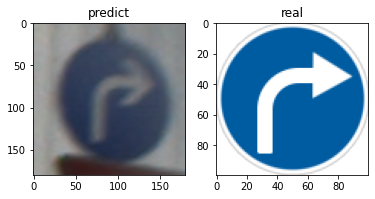

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
틀렸음


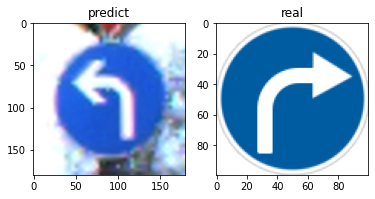

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
틀렸음


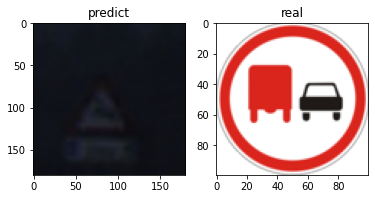

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


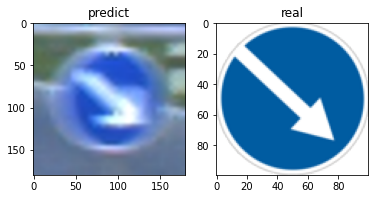

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
틀렸음


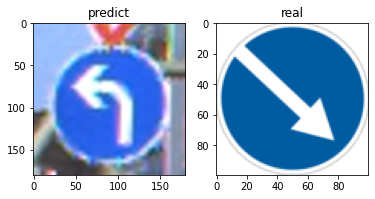

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
틀렸음


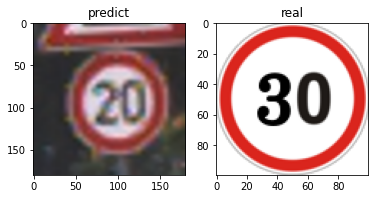

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


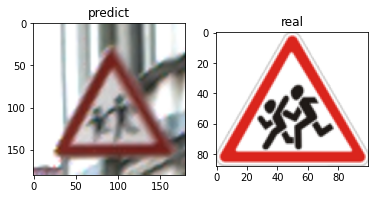

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


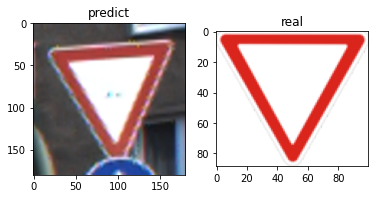

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


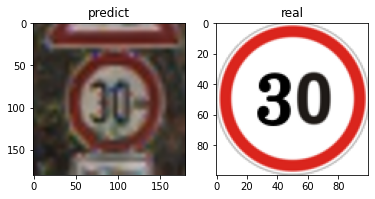

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
틀렸음


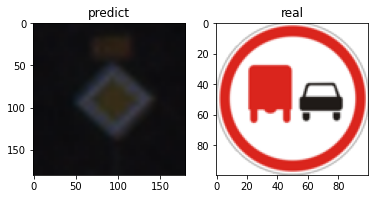

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


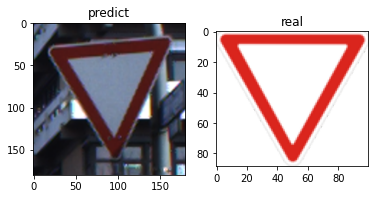

--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
틀렸음


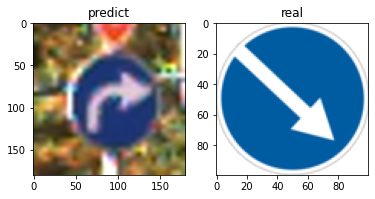

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


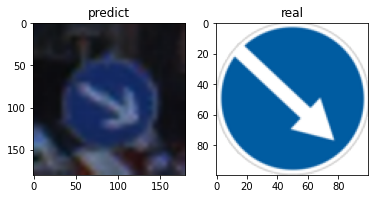

--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
정답


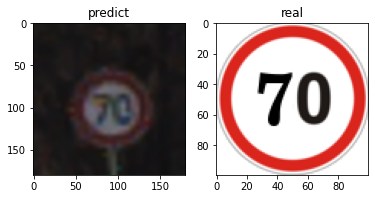

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
틀렸음


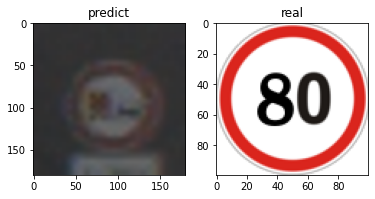

--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
정답


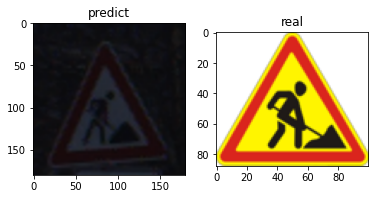

--------------------------------------------------


In [112]:
from glob import glob
import pandas as pd
from PIL import Image
file_list = glob('/content/data/test/*.png')
meta =pd.read_csv('/content/Meta.csv')
for file in file_list[:30]:
  img=Image.open(file)
  img=img.resize((180,180))
  imgArr=np.array(img)
  inputimage=imgArr.reshape(1,180,180,3)
  predictNum=model.predict(inputimage)  # 1-1에서 모델제작할때 
  num=np.argmax(predictNum)  #3번값이 제일큼
  classified = class_names[num]
  plt.subplot(121)
  plt.title('predict')
  plt.imshow(img)
  plt.subplot(122)
  plt.title('real')
  a = Image.open('/content/'+meta[meta['ClassId'] == int(class_names[num])]['Path'].values[0])
  plt.imshow(a)
  real_class = test[test['index'] == int(file.split('/')[-1].replace('.png',''))]['ClassId']
  if int(classified) == real_class.values[0]:
    print('정답')
  else:
    print('틀렸음')
  plt.show()
  print('-'*50)